In [0]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [0]:
batch_size = 128
learning_rate = 0.001

input_size = 28*28
num_classes = 10

In [3]:
device = torch.device("cuda:0")

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


Dataset & Data loaders

In [0]:
dataset = MNIST(root='data/', train=True, 
                transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, 
                transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 3


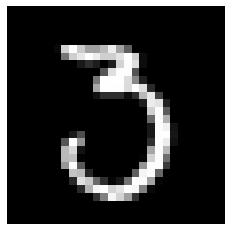

In [5]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
plt.axis("off")
print('Label:', label)

Model

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
class MnistModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, X):
        X = X.reshape(-1, 784)
        outputs = self.linear(X)
        return outputs

    def train_step(self, batch):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {'loss': loss, 'acc': acc}, loss
    
    def valid_step(self, batch):
        inputs, labels = batch 
        inputs, labels = inputs.to(device), labels.to(device)
        out = self(inputs)                 
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)    
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        

    def train_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}

    def valid_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
            print(f"Epoch [{epoch+1}] -> loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
    
model = MnistModel()
model.to(device)

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

Training

In [0]:
def evaluate(model, val_loader):
    outputs = [model.valid_step(batch) for batch in val_loader]
    return model.valid_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    train_history = []

    for epoch in range(epochs):
        # Training Phase 
        
        for batch in train_loader:
            info, loss = model.train_step(batch)
            
            # contains batch loss and acc for training phase
            train_history.append(info)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_result = model.train_epoch_end(train_history)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}

        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [9]:
result = evaluate(model, val_loader)
result

{'val_acc': 0.07343749701976776, 'val_loss': 2.3184847831726074}

In [10]:
history = fit(100, 0.001, model, train_loader, val_loader)

Epoch [10] -> loss: 1.3285, acc: 0.7492, val_loss: 0.8862, val_acc: 0.8351
Epoch [20] -> loss: 1.0442, acc: 0.7968, val_loss: 0.6675, val_acc: 0.8541
Epoch [30] -> loss: 0.9024, acc: 0.8178, val_loss: 0.5794, val_acc: 0.8634
Epoch [40] -> loss: 0.8145, acc: 0.8305, val_loss: 0.5302, val_acc: 0.8696
Epoch [50] -> loss: 0.7535, acc: 0.8393, val_loss: 0.4982, val_acc: 0.8745
Epoch [60] -> loss: 0.7081, acc: 0.8460, val_loss: 0.4753, val_acc: 0.8779
Epoch [70] -> loss: 0.6726, acc: 0.8512, val_loss: 0.4581, val_acc: 0.8803
Epoch [80] -> loss: 0.6440, acc: 0.8554, val_loss: 0.4445, val_acc: 0.8847
Epoch [90] -> loss: 0.6203, acc: 0.8590, val_loss: 0.4334, val_acc: 0.8862
Epoch [100] -> loss: 0.6002, acc: 0.8620, val_loss: 0.4241, val_acc: 0.8874


Text(0.5, 1.0, 'Accuracy vs. epochs')

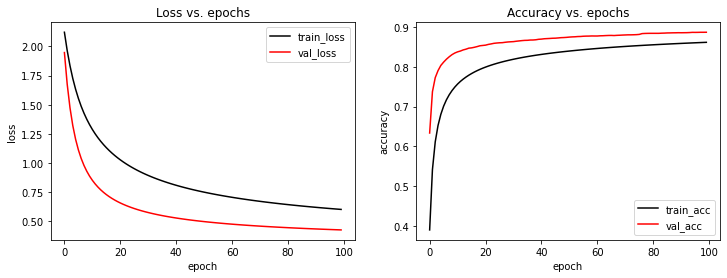

In [11]:
train_losses = [r['loss'] for r in history]
val_losses = [r['val_loss'] for r in history]
train_acc = [r['acc'] for r in history]
val_acc = [r['val_acc'] for r in history]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, c='k', label="train_loss")
plt.plot(val_losses, c='r', label="val_loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, c='k', label="train_acc")
plt.plot(val_acc, c='r', label="val_acc")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. epochs')

In [12]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.895703136920929, 'val_loss': 0.3904913365840912}

Prediction

In [0]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


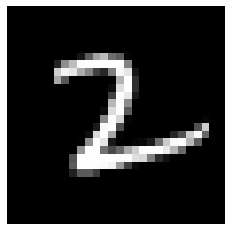

In [14]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
plt.axis("off")
print('Label:', label, ', Predicted:', predict_image(img.to(device), model))

Save Model

In [0]:
torch.save(model.state_dict(), 'mnist-logistic.pth')